In [1]:
from fastai.conv_learner import *
from fastai.dataset import *
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
import math


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
MODEL_NAME = 'Resnet50'
PATH  = "./input"
TRAIN = f'{PATH}/train/'
TEST = f'{PATH}/test/'
LABELS = f'{PATH}/train.csv'
SAMPLE_SUB = f'{PATH}/sample_submission.csv'

In [3]:
# Backbone architecture
arch = resnet50
# Number of workers for data preprocessing
num_workers = 6

In [4]:
df = pd.read_csv(LABELS).set_index('Image')
new_whale_df = df[df.Id == "new_whale"] # only new_whale dataset

train_df = df[~(df.Id == "new_whale")] # no new_whale dataset, used for training
unique_labels = np.unique(train_df.Id.values)

labels_dict = dict()
labels_list = []
for i in range(len(unique_labels)):
    labels_dict[unique_labels[i]] = i
    labels_list.append(unique_labels[i])
print("Number of classes: {}".format(len(unique_labels)))
train_names = train_df.index.values
train_df.Id = train_df.Id.apply(lambda x: labels_dict[x])
train_labels = np.asarray(train_df.Id.values)

test_names = [f for f in os.listdir(TEST)]

Number of classes: 5004


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Count for class new_whale: 1


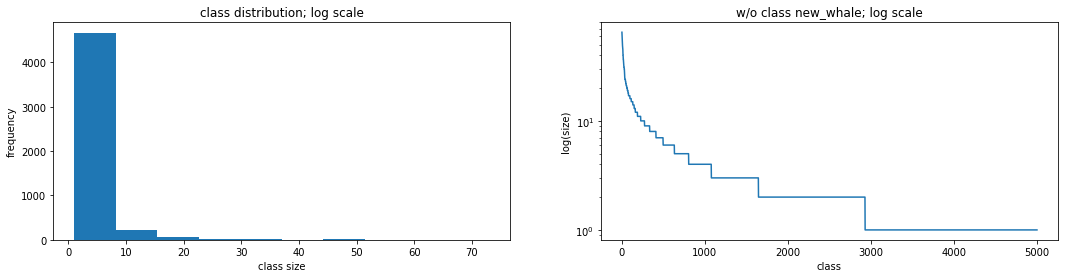

In [5]:
labels_count = train_df.Id.value_counts()

plt.figure(figsize=(18, 4))
plt.subplot(121)
_, _,_ = plt.hist(labels_count.values)
plt.ylabel("frequency")
plt.xlabel("class size")

plt.title('class distribution; log scale')
labels_count.head()

print("Count for class new_whale: {}".format(labels_count[0]))
plt.subplot(122)
_ = plt.plot(labels_count[1:].values)
plt.title('w/o class new_whale; log scale')
plt.xlabel("class")
plt.ylabel("log(size)")
plt.gca().set_yscale('log')

In [6]:
dup = []
for idx,row in train_df.iterrows():
    if labels_count[row['Id']] < 5:
        dup.extend([idx]*math.ceil((5 - labels_count[row['Id']])/labels_count[row['Id']]))
train_names = np.concatenate([train_names, dup])
train_names = train_names[np.random.RandomState(seed=42).permutation(train_names.shape[0])]
len(train_names)

31925

In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42069)
for train_idx, val_idx in sss.split(train_names, np.zeros(train_names.shape)):
    tr_n, val_n = train_names[train_idx], train_names[val_idx]
print(len(tr_n), len(val_n))

25540 6385


In [8]:
class HWIDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.train_df = train_df
        super().__init__(fnames, transform, path)

    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        img = cv2.resize(img, (self.sz, self.sz))
        return img

    def get_y(self, i):
        if (self.path == TEST): return 0
        return self.train_df.loc[self.fnames[i]]['Id']

    def get_c(self):
        return len(unique_labels)

In [9]:
def get_data(sz, batch_size, test_names=test_names, test_dir=TEST):
    """
    Read data and do augmentations
    """
    aug_tfms = [RandomRotateZoom(deg=20, zoom=2, stretch=1),
                RandomLighting(0.2, 0.2, tfm_y=TfmType.NO),
                RandomBlur(blur_strengths=3,tfm_y=TfmType.NO),
                RandomFlip(tfm_y=TfmType.NO)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO,
                           aug_tfms=aug_tfms)
    ds = ImageData.get_ds(HWIDataset, (tr_n[:-(len(tr_n) % batch_size)], TRAIN),
                          (val_n, TRAIN), tfms, test=(test_names, test_dir))
    md = ImageData("./", ds, batch_size, num_workers=num_workers, classes=None)
    return md

In [10]:
image_size = 224
batch_size = 96
md = get_data(image_size, batch_size)
extra_fc_layers_size = []
learn = ConvLearner.pretrained(arch, md, xtra_fc=extra_fc_layers_size) 
learn.opt_fn = optim.Adam

In [12]:
print('Number of layer groups:', len(learn.get_layer_groups()), '\t(first 2 groups is pretrained backbone)')
print('This is our extra thin on top of the backbone Resnet50 architecture:')
learn.get_layer_groups()[2]

Number of layer groups: 3 	(first 2 groups is pretrained backbone)
This is our extra thin on top of the backbone Resnet50 architecture:


Sequential(
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.5)
  (2): Linear(in_features=4096, out_features=5004, bias=True)
  (3): LogSoftmax()
)

In [16]:
base_lr = 1e-4 # lr for the backbone
fc_lr = 1e-3 # lr for the classifer

lrs = [base_lr, base_lr, fc_lr]
# Freeze backbone and train the classifier for 2 epochs
learn.fit(lrs=lrs, n_cycle=2, cycle_len=None)


epoch      trn_loss   val_loss   accuracy                   
    0      7.087653   5.833532   0.185591  
    1      4.420158   3.687444   0.454816                   



[3.6874438127130853, 0.4548159858726764]

In [17]:
# Unfreeze backbone and continue training for 9 epochs
learn.unfreeze()
learn.fit(lrs, n_cycle=1, cycle_len=None)

epoch      trn_loss   val_loss   accuracy                   
    0      4.487634   3.303788   0.493344  



[3.3037881392282533, 0.49334378712048454]

In [18]:
learn.fit(lrs, n_cycle=1, cycle_len=3, use_clr=(10, 5), cycle_save_name="1_resnet50_2")

epoch      trn_loss   val_loss   accuracy                   
    0      3.206746   2.540809   0.610493  
    1      1.194542   1.122965   0.810807                   
    2      0.506933   0.875718   0.854503                    



[0.8757183048439474, 0.854502760197095]

In [19]:
learn.fit(lrs, n_cycle=3, cycle_len=1, use_clr=(10, 5), cycle_save_name="2_resnet50_2")

epoch      trn_loss   val_loss   accuracy                   
    0      1.694076   1.410766   0.806108  
    1      0.745337   0.909022   0.850274                    
    2      0.464716   0.779244   0.865779                    



[0.7792441409084138, 0.8657791884317002]

In [11]:
learn.load("subm1_resnet50_2")

In [21]:
learn.save("subm1_resnet50_2")

In [22]:
preds_v,y_v = learn.TTA(is_test=False,n_aug=2)
preds_v = np.stack(preds_v, axis=-1)
preds_v = np.exp(preds_v)
preds_v = preds_v.mean(axis=-1)
y_v += 1

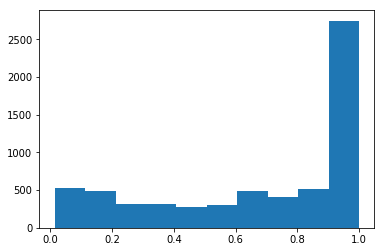

In [23]:
preds_v_max = np.max(preds_v,axis=1)
_,_,_ = plt.hist(preds_v_max)

In [25]:
TEST=TRAIN # sorry
total_new_whale = len(new_whale_df.index.values)
md = get_data(image_size, batch_size, test_names=new_whale_df.index.values[:int(total_new_whale*0.2)], test_dir=TRAIN)
learn.set_data(md)
preds_w,y_w = learn.TTA(is_test=True,n_aug=2)
preds_w = np.stack(preds_w, axis=-1)
preds_w = np.exp(preds_w)
preds_w = preds_w.mean(axis=-1)

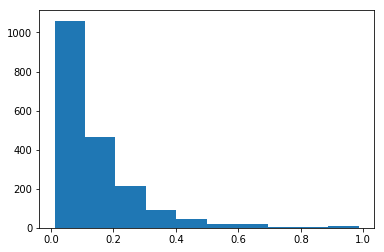

In [26]:
preds_w_max = np.max(preds_w,axis=1)
_,_,_ = plt.hist(preds_w_max)

In [27]:
y = np.concatenate([y_v,y_w])
preds = np.concatenate([preds_v, preds_w],axis=0)
preds = np.concatenate([np.zeros((preds.shape[0],1)), preds],axis=1)

In [28]:
def map5(X, y):
    score = 0
    for i in range(X.shape[0]):
        pred = X[i].argsort()[-5:][::-1]
        for j in range(pred.shape[0]):
            if pred[j] == y[i]:
                score += (5 - j)/5
                break
    return score/X.shape[0]

best_th = 0
best_score = 0
for th in np.arange(0.1, 0.801, 0.01):
    preds[:,0] = th
    score = map5(preds, y)
    if score > best_score:
        best_score = score
        best_th = th
    print("Threshold = {:.3f}, MAP5 = {:.3f}".format(th,score))

Threshold = 0.100, MAP5 = 0.856
Threshold = 0.110, MAP5 = 0.859
Threshold = 0.120, MAP5 = 0.862
Threshold = 0.130, MAP5 = 0.863
Threshold = 0.140, MAP5 = 0.864
Threshold = 0.150, MAP5 = 0.865
Threshold = 0.160, MAP5 = 0.866
Threshold = 0.170, MAP5 = 0.867
Threshold = 0.180, MAP5 = 0.868
Threshold = 0.190, MAP5 = 0.868
Threshold = 0.200, MAP5 = 0.868
Threshold = 0.210, MAP5 = 0.869
Threshold = 0.220, MAP5 = 0.869
Threshold = 0.230, MAP5 = 0.869
Threshold = 0.240, MAP5 = 0.869
Threshold = 0.250, MAP5 = 0.870
Threshold = 0.260, MAP5 = 0.870
Threshold = 0.270, MAP5 = 0.870
Threshold = 0.280, MAP5 = 0.870
Threshold = 0.290, MAP5 = 0.870
Threshold = 0.300, MAP5 = 0.870
Threshold = 0.310, MAP5 = 0.870
Threshold = 0.320, MAP5 = 0.869
Threshold = 0.330, MAP5 = 0.869
Threshold = 0.340, MAP5 = 0.869
Threshold = 0.350, MAP5 = 0.869
Threshold = 0.360, MAP5 = 0.868
Threshold = 0.370, MAP5 = 0.868
Threshold = 0.380, MAP5 = 0.867
Threshold = 0.390, MAP5 = 0.867
Threshold = 0.400, MAP5 = 0.867
Threshol

KeyboardInterrupt: 

In [13]:
best_th = 0.31

In [12]:
TEST = './input/test/'
md = get_data(image_size, batch_size, test_names=test_names, test_dir=TEST)
learn.set_data(md)
preds_t,y_t = learn.TTA(is_test=True,n_aug=8)

NameError: name 'best_th' is not defined

In [ ]:
preds_t = np.stack(preds_t, axis=-1)
preds_t = np.exp(preds_t)
preds_t = preds_t.mean(axis=-1)


In [14]:
preds_t = np.concatenate([np.zeros((preds_t.shape[0],1))+best_th, preds_t],axis=1)

In [15]:
np.save("preds_whale50_2_preds", preds_t)

In [16]:
aa = 0 if labels_list[0] != "new_whale" else 1

In [17]:
aa

0

In [20]:
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.Image)
labels_list = ["new_whale"]+labels_list if labels_list[0] != "new_whale" else labels_list
pred_list = [[labels_list[i] for i in p.argsort()[-5:][::-1]] for p in preds_t]
pred_dic = dict((key, value) for (key, value) in zip(learn.data.test_ds.fnames,pred_list))
pred_list_cor = [' '.join(pred_dic[id]) for id in sample_list]
df = pd.DataFrame({'Image':sample_list,'Id': pred_list_cor})
df.to_csv('submission_rn_2.csv', header=True, index=False)
df.head()

,Image,Id
0,00028a005.jpg,new_whale w_bb2c919 w_0e9f07a w_f5bf6df w_04003e9
1,000dcf7d8.jpg,w_4132bb8 new_whale w_f2075ef w_adedd1f w_df86a42
2,000e7c7df.jpg,new_whale w_9ba4a9a w_a743e09 w_15951db w_0a84ac5
3,0019c34f4.jpg,new_whale w_8b86b95 w_9c506f6 w_f765256 w_f8511e9
4,001a4d292.jpg,new_whale w_9e18daa w_3ef0017 w_92ac4b2 w_d210085


In [ ]:
learn.fit(lrs, n_cycle=3, cycle_len=1, use_clr=(10, 5), cycle_save_name="3_resnet50_2")

epoch      trn_loss   val_loss   accuracy                   
    0      1.180431   1.151356   0.843383  
 16%|█▌        | 43/266 [00:37<02:59,  1.24it/s, loss=0.842]

In [21]:
learn.fit(lrs, n_cycle=3, cycle_len=2, use_clr=(10, 5), cycle_save_name="4_resnet50_2")

epoch      trn_loss   val_loss   accuracy                   
    0      2.956882   1.012938   0.836     
    1      1.88819    0.522162   0.899                      
    2      1.930236   0.381375   0.913                      
    3      0.955006   0.110373   0.976                       
    4      1.051642   0.116775   0.966                       
    5      0.538573   0.020373   0.999                       



[0.02037325496226549, 0.9990000038146972]

In [23]:
preds_t,y_t = learn.TTA(is_test=True,n_aug=8)
preds_t = np.stack(preds_t, axis=-1)
preds_t = np.exp(preds_t)
preds_t = preds_t.mean(axis=-1)

In [24]:
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.Image)
pred_list = [[labels_list[i] for i in p.argsort()[-5:][::-1]] for p in preds_t]
pred_dic = dict((key, value) for (key, value) in zip(learn.data.test_ds.fnames,pred_list))
pred_list_cor = [' '.join(pred_dic[id]) for id in sample_list]
df = pd.DataFrame({'Image':sample_list,'Id': pred_list_cor})
df.to_csv('submission_2{}.csv'.format(MODEL_NAME), header=True, index=False)
df.head()

,Image,Id
0,00028a005.jpg,new_whale w_dec7ffd w_69b5ace w_f442602 w_97d60b9
1,000dcf7d8.jpg,w_4132bb8 new_whale w_e3956f5 w_94f41dc w_3108dce
2,000e7c7df.jpg,new_whale w_a743e09 w_9ba4a9a w_b5e6c80 w_94c3bf0
3,0019c34f4.jpg,new_whale w_59052ad w_8b86b95 w_91b678a w_71fa596
4,001a4d292.jpg,new_whale w_9e18daa w_5688262 w_3ef0017 w_16c264e


In [31]:
!ls

fastai		    submission1.csv	     tmp		 Whales.ipynb
input		    submission.csv	     whales50.ipynb
learn_whales.ipynb  submission_Resnet50.csv  whales50-V2.ipynb
models		    submission_rn_2.csv      Whales-Copy1.ipynb


In [32]:
!kaggle competitions submit -c humpback-whale-identification -f "submission_rn_2.csv" -m "resnet50 v2 train no whale, threshold, strat sampl"

100%|█████████████████████████████████████████| 498k/498k [00:02<00:00, 211kB/s]
Successfully submitted to Humpback Whale Identification

In [33]:
!kaggle competitions submissions humpback-whale-identification

fileName                 date                 description                                         status    publicScore  privateScore  
-----------------------  -------------------  --------------------------------------------------  --------  -----------  ------------  
submission_rn_2.csv      2018-12-06 15:57:14  resnet50 v2 train no whale, threshold, strat sampl  complete  0.446        None          
submission_Resnet50.csv  2018-12-06 12:30:39  resnet50 no val sampling                            complete  0.587        None          
submission1.csv          2018-12-04 19:40:43  second                                              complete  0.362        None          
submission.csv           2018-12-03 18:02:32  "1st"                                               complete  0.324        None          


In [31]:
!kaggle competitions leaderboard --show humpback-whale-identification

 teamId  teamName                      submissionDate       score  
-------  ----------------------------  -------------------  -----  
2471928  NPU-ASGO                      2018-12-06 01:11:36  0.889  
2471984  Zihan Huang                   2018-12-05 09:22:39  0.826  
2479830  pi-null-mezon                 2018-12-06 06:57:27  0.823  
2466533  yvan                          2018-12-06 04:33:28  0.821  
2486517  Philip                        2018-12-06 03:12:27  0.775  
2471947  Yifei Yang                    2018-12-04 11:57:48  0.732  
2473929  Orest Kupyn                   2018-12-05 18:09:27  0.719  
2471589  Hansoluo                      2018-12-06 06:14:54  0.701  
2468444  [ods.ai] Artem.Sanakoev       2018-12-06 04:27:23  0.695  
2465705  YoungMin Ro                   2018-12-06 02:33:46  0.679  
2483259  yao                           2018-12-05 11:06:27  0.640  
2471819  Siarhei Fedartsou             2018-12-05 05:21:27  0.628  
2475771  Chih Hao Ma                   2018-12-0